In [46]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp

%matplotlib inline

In [47]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Yash
[nltk_data]     Reddy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Yash
[nltk_data]     Reddy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
# Load the training data to a pandas DataFrame
tr_data = pd.read_csv('train.csv')
#print the first 10 rows of the dataframe
tr_data.head(3)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1


In [49]:
# Load the testing data to a pandas DataFrame
tt_data = pd.read_csv('test.csv')
#print the first 10 rows of the dataframe
tt_data.head(3)

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...


In [50]:
# Total number of rows and columns
tr_data.shape, tt_data.shape

((20800, 5), (5200, 4))

In [51]:
# counting the number of missing values
tr_data.isnull().sum(), tt_data.isnull().sum()

(id           0
 title      558
 author    1957
 text        39
 label        0
 dtype: int64,
 id          0
 title     122
 author    503
 text        7
 dtype: int64)

In [52]:
tr_data.dropna(inplace=True), tt_data.dropna(inplace=True)

(None, None)

In [53]:
tr_data.shape, tt_data.shape

((18285, 5), (4575, 4))

In [54]:
tr_data['id'].nunique(), tr_data['title'].nunique(), tr_data['author'].nunique(), tr_data['text'].nunique()

(18285, 17931, 3838, 18017)

In [55]:
tt_data['id'].nunique(), tt_data['title'].nunique(), tt_data['author'].nunique(), tt_data['text'].nunique()

(4575, 4561, 1639, 4517)

In [56]:
tr_data.drop(['id'], axis=1, inplace=True)
tt_data.drop(['id'], axis=1, inplace=True)

In [57]:
tr_data.drop_duplicates(subset=('title'),keep=False,inplace=True,ignore_index=True)
tr_data.drop_duplicates(subset=('text'),keep=False,inplace=True,ignore_index=True)
tt_data.drop_duplicates(subset=('title'),keep=False,inplace=True,ignore_index=True)
tt_data.drop_duplicates(subset=('text'),keep=False,inplace=True,ignore_index=True)


In [58]:
tr_data.shape, tt_data.shape

((17376, 4), (4477, 3))

In [59]:
# counting the number of missing values
tr_data.isnull().sum(), tt_data.isnull().sum()

(title     0
 author    0
 text      0
 label     0
 dtype: int64,
 title     0
 author    0
 text      0
 dtype: int64)

In [60]:
tr_data.dtypes, tt_data.dtypes

(title     object
 author    object
 text      object
 label      int64
 dtype: object,
 title     object
 author    object
 text      object
 dtype: object)

<Axes: title={'center': 'Authors with most publications'}, ylabel='author'>

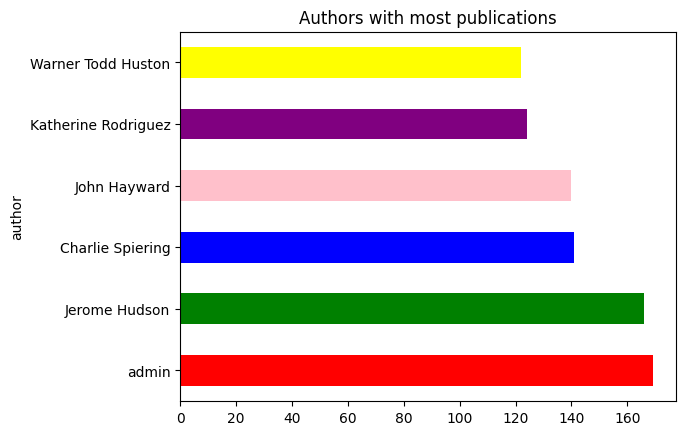

In [61]:
plt.title("Authors with most publications")
tr_data['author'].value_counts()[1:7].plot(kind='barh',color = ['red', 'green','blue','pink','purple','yellow'])

In [62]:
tr_data['label'].value_counts()

label
0    10351
1     7025
Name: count, dtype: int64

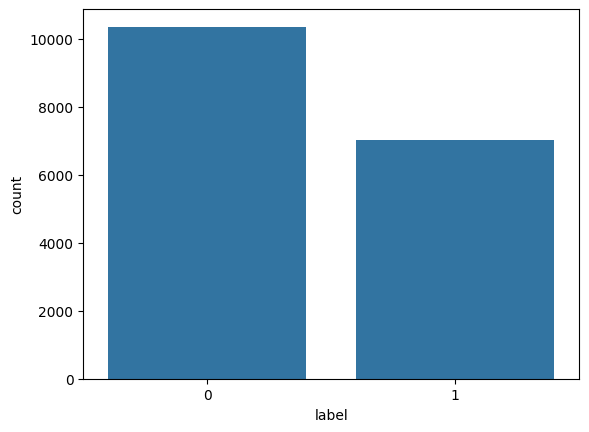

In [63]:
sns.countplot(data=tr_data, x = 'label')
plt.show()

In [64]:
#merging the author name and text
tr_data['content'] = tr_data['author'] + ' ' + tr_data['title']
print(tr_data['content'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
17371    Lee Stranahan Trump: Putin ’Very Smart’ to Not...
17372    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
17373    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
17374    Michael J. de la Merced and Rachel Abrams Macy...
17375    Alex Ansary NATO, Russia To Hold Parallel Exer...
Name: content, Length: 17376, dtype: object


In [65]:
#merging the author name and text
tt_data['content'] = tt_data['author'] + ' ' + tt_data['title']
print(tt_data['content'])

0       David Streitfeld Specter of Trump Loosens Tong...
1       Common Dreams #NoDAPL: Native American Leaders...
2       Daniel Victor Tim Tebow Will Attempt Another C...
3       Truth Broadcast Network Keiser Report: Meme Wa...
4       Pam Key Pelosi Calls for FBI Investigation to ...
                              ...                        
4472    Pam Key Trump on If ’Tapes’ Exist of Comey Con...
4473    Jody Rosen The Bangladeshi Traffic Jam That Ne...
4474    Sheryl Gay Stolberg John Kasich Signs One Abor...
4475    Mike McPhate California Today: What, Exactly, ...
4476    Teddy Wayne Awkward Sex, Onscreen and Off - Th...
Name: content, Length: 4477, dtype: object


In [66]:
sw = stopwords.words('english')
sw.remove('not')
sw.remove('no')
sw.remove('against')
sw.remove('don\'t')
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 

In [67]:
port_stem = PorterStemmer()
def stemming(content):
    stemmed_content = re.sub('[^a-z A-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in sw]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [68]:
tr_data['content'] = tr_data['content'].apply(stemming)
print(tr_data['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
17371    lee stranahan trump putin smart not retali oba...
17372    jerom hudson rapper trump poster child white s...
17373    benjamin hoffman n f l playoff schedul matchup...
17374    michael j de la merc rachel abram maci said re...
17375    alex ansari nato russia hold parallel exercis ...
Name: content, Length: 17376, dtype: object


In [69]:
tt_data['content'] = tt_data['content'].apply(stemming)
print(tt_data['content'])

0       david streitfeld specter trump loosen tongu no...
1       common dream nodapl nativ american leader vow ...
2       daniel victor tim tebow attempt anoth comeback...
3        truth broadcast network keiser report meme war e
4       pam key pelosi call fbi investig find russian ...
                              ...                        
4472    pam key trump tape exist comey convers tell ma...
4473    jodi rosen bangladeshi traffic jam never end n...
4474    sheryl gay stolberg john kasich sign one abort...
4475    mike mcphate california today exactli sushi ne...
4476        teddi wayn awkward sex onscreen new york time
Name: content, Length: 4477, dtype: object


In [70]:
# separating the data & label
X = tr_data.drop(columns = 'label', axis = 1)
Y = tr_data['label']

In [71]:
#converting the textual data to numerical data
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(tr_data['content'])
x_test = vectorizer.transform(tt_data['content'])

In [72]:
x_train, x_test

(<17376x15780 sparse matrix of type '<class 'numpy.float64'>'
 	with 188465 stored elements in Compressed Sparse Row format>,
 <4477x15780 sparse matrix of type '<class 'numpy.float64'>'
 	with 46225 stored elements in Compressed Sparse Row format>)

In [73]:
model = LogisticRegression()
model.fit(x_train, Y)

LogisticRegression()

In [74]:
pred = model.predict(x_test)
pred

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [75]:
#creating 'label' column for test dataframe
tt_data['label'] = pred
tt_data

,title,author,text,content,label
0,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",david streitfeld specter trump loosen tongu no...,0
1,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,common dream nodapl nativ american leader vow ...,1
2,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",daniel victor tim tebow attempt anoth comeback...,0
3,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,truth broadcast network keiser report meme war e,1
4,Pelosi Calls for FBI Investigation to Find Out...,Pam Key,"Sunday on NBC’s “Meet the Press,” House Minori...",pam key pelosi call fbi investig find russian ...,0
...,...,...,...,...,...
4472,Trump on If ’Tapes’ Exist of Comey Conversatio...,Pam Key,Pres. Trump on if “tapes” exist of his convers...,pam key trump tape exist comey convers tell ma...,0
4473,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,Of all the dysfunctions that plague the world’...,jodi rosen bangladeshi traffic jam never end n...,0
4474,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...,sheryl gay stolberg john kasich sign one abort...,0
4475,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,Good morning. (Want to get California Today by...,mike mcphate california today exactli sushi ne...,0


In [76]:
# accuracy score on the training data
X_train_prediction = model.predict(x_train)
training_data_accuracy = accuracy_score(Y, X_train_prediction)
print('Accuracy score of the training data: ', training_data_accuracy)

Accuracy score of the training data:  0.9921731123388582


In [77]:
cm = confusion_matrix(Y, X_train_prediction)
cm

array([[10259,    92],
       [   44,  6981]], dtype=int64)

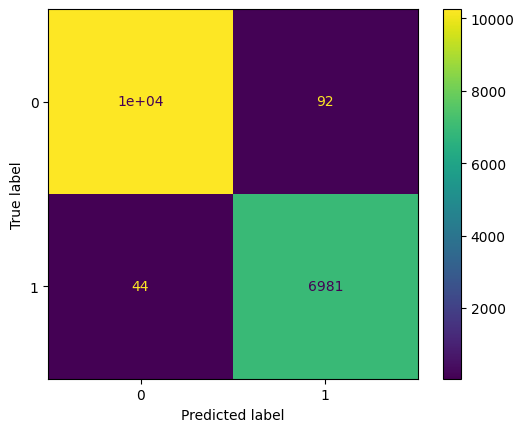

In [78]:
# pass it a trained model: it makes predictions for Y and compares them to x_train_prediction
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [79]:
pickle.dump(vectorizer, open('vector.pkl', 'wb'))
pickle.dump(model, open("model.pkl", "wb"))
vector_form = pickle.load(open('vector.pkl', 'rb'))
load_model = pickle.load(open('model.pkl', 'rb'))

In [80]:
def fake_news(news):
    news = stemming(news)
    input_data = [news]
    vect_form = vector_form.transform(input_data)
    prediction = load_model.predict(vect_form)
    return prediction

In [81]:
tr_data['text'][5]

'In these trying times, Jackie Mason is the Voice of Reason. [In this week’s exclusive clip for Breitbart News, Jackie discusses the looming threat of North Korea, and explains how President Donald Trump could win the support of the Hollywood left if the U. S. needs to strike first.  “If he decides to bomb them, the whole country will be behind him, because everybody will realize he had no choice and that was the only thing to do,” Jackie says. “Except the Hollywood left. They’ll get nauseous. ” “[Trump] could win the left over, they’ll fall in love with him in a minute. If he bombed them for a better reason,” Jackie explains. “Like if they have no transgender toilets. ” Jackie also says it’s no surprise that Hollywood celebrities didn’t support Trump’s strike on a Syrian airfield this month. “They were infuriated,” he says. “Because it might only save lives. That doesn’t mean anything to them. If it only saved the environment, or climate change! They’d be the happiest people in the wo

In [82]:
val = fake_news('In these trying times, Jackie Mason is the Voice of Reason. [In this week’s exclusive clip for Breitbart News, Jackie discusses the looming threat of North Korea, and explains how President Donald Trump could win the support of the Hollywood left if the U. S. needs to strike first.  “If he decides to bomb them, the whole country will be behind him, because everybody will realize he had no choice and that was the only thing to do,” Jackie says. “Except the Hollywood left. They’ll get nauseous. ” “[Trump] could win the left over, they’ll fall in love with him in a minute. If he bombed them for a better reason,” Jackie explains. “Like if they have no transgender toilets. ” Jackie also says it’s no surprise that Hollywood celebrities didn’t support Trump’s strike on a Syrian airfield this month. “They were infuriated,” he says. “Because it might only save lives. That doesn’t mean anything to them. If it only saved the environment, or climate change! They’d be the happiest people in the world. ” Still, Jackie says he’s got nothing against Hollywood celebs. They’ve got a tough life in this country. Watch Jackie’s latest clip above.   Follow Daniel Nussbaum on Twitter: @dznussbaum')

In [83]:
if val == [0]:
    print('reliable')
else:
    print('unreliable')

reliable


In [84]:
tr_data.head(10)

,title,author,text,label,content
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,darrel lucu hous dem aid even see comey letter...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,daniel j flynn flynn hillari clinton big woman...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,consortiumnew com truth might get fire
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,jessica purkiss civilian kill singl us airstri...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,howard portnoy iranian woman jail fiction unpu...
5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0,daniel nussbaum jacki mason hollywood would lo...
6,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0,alissa j rubin beno hamon win french socialist...
7,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0,megan twohey scott shane back channel plan ukr...
8,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0,aaron klein obama organ action partner soro li...
9,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0,chri tomlinson bbc comedi sketch real housew i...
